In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class Environment:
    def __init__(self, K, dynamic_plot=False):
        self.K = K
        self.dynamic_plot = dynamic_plot
        self.fig = None
        
    def reset(self):
        self.steps = 0
        self.mean = np.random.randn(self.K)
        self.optimal_action = np.argmax(self.mean)
        self.num_chose_opt = 0
        
        if self.dynamic_plot:
            self.prob_chose_opt = [0]
            self.init_plot()
        
    def init_plot(self):
        if not self.fig:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111)
            self.ax.axis(xmin=0, xmax=self.steps+1, ymin=0, ymax=1)
            plt.ion()
            plt.pause(0.0001)
            self.fig.show()
            self.fig.canvas.draw()

    def update_plot(self):
        self.prob_chose_opt.append(self.num_chose_opt / self.steps)
        self.ax.clear()
        plt.pause(0.0001)
        self.ax.axis(xmin=0, xmax=self.steps+1, ymin=0, ymax=1)
        self.ax.plot(range(self.steps+1), self.prob_chose_opt, '-r', lw=2)
        self.fig.canvas.draw()
        
    def step(self, action):    
        if action >= K:
            raise ValueError("The action should be less than {0}!".format(self.K-1))
            
        self.steps += 1
        if action == self.optimal_action:
            self.num_chose_opt += 1
            
        if self.dynamic_plot:
            self.update_plot()
            
        return self.mean[action] + np.random.randn()
    
class Agent:
    def __init__(self, K, eps):
        self.K = K
        self.eps = eps
        self.reset()
        
    def reset(self):
        self.Q = np.zeros(K)
        self.last_action = None
        self.steps = np.zeros(K)
            
    def get_action(self):
        if np.random.random() <= self.eps:
            self.last_action = np.random.randint(0, self.K)
            self.steps[self.last_action] += 1
            return self.last_action
        
        best_reward = np.where(self.Q == np.amax(self.Q))[0]
        self.last_action = np.random.choice(best_reward)
        self.steps[self.last_action] += 1
        return self.last_action
    
    def update_policy(self, reward):
        self.Q[self.last_action] +=  (1/self.steps[self.last_action]) * (reward - self.Q[self.last_action])
            

In [10]:
def run(env, agent, num_steps):
    reward_per_step = np.zeros(num_steps)
    num_chose_opt = 0
    prob_chose_opt = np.zeros(num_steps)
    for i in range(num_steps):
        action = agent.get_action()
        if action == env.optimal_action:
            num_chose_opt += 1
        prob_chose_opt[i] = num_chose_opt / (i+1)
        reward = env.step(action)
        reward_per_step[i] = reward
        agent.update_policy(reward)
        
    return reward_per_step, prob_chose_opt


In [21]:
K = 10
eps = [0.01, 0.1, 0]
num_runs = 2000
num_steps = 5000
average_reward = {}
prob_choose_opt = {}

for i in range(len(eps)):
    key = "epsilon{0}".format(eps[i])
    average_reward[key] = np.zeros(num_steps)
    prob_choose_opt[key] = np.zeros(num_steps)

    env = Environment(10)
    agent = Agent(K, eps[i])
    
    for i in range(num_runs):
        env.reset()
        agent.reset()

        rew, prob = run(env, agent, num_steps)
        average_reward[key] += rew / num_runs
        prob_choose_opt[key] += prob / num_runs

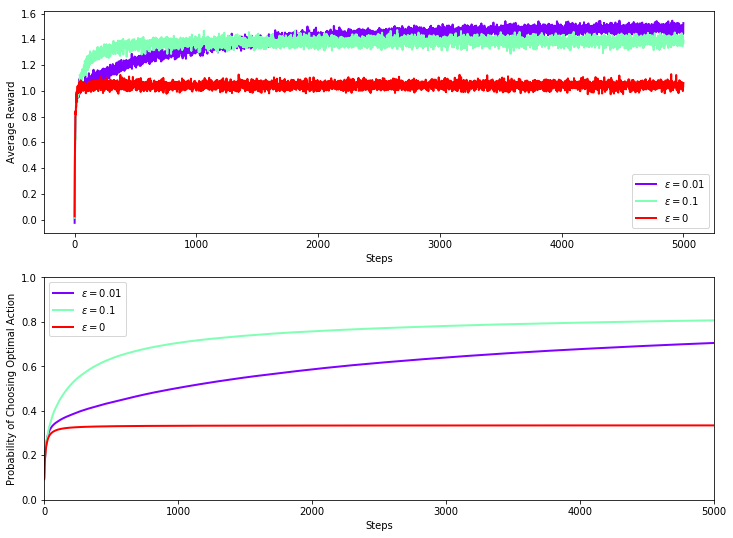

In [22]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Reward")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Probability of Choosing Optimal Action")
ax2.axis(xmin=0, xmax=num_steps, ymin=0, ymax=1)
color = iter(plt.cm.rainbow(np.linspace(0,1,len(eps))))

for i in range(len(eps)):
    clr = next(color)
    ax1.plot(range(num_steps), average_reward["epsilon{0}".format(eps[i])], lw=2, 
             c=clr, label=r'$\epsilon = {0}$'.format(eps[i]))
    ax2.plot(range(num_steps), prob_choose_opt["epsilon{0}".format(eps[i])], lw=2, 
             c=clr, label=r'$\epsilon = {0}$'.format(eps[i]))
    
ax1.legend(loc="lower right")    
ax2.legend(loc="upper left")    

plt.show()